In [ ]:
#for selecting vecotr of 4 use 
#random.sample(data, k=4)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [23]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import time
from numpy.random import uniform
import multiprocessing
#from multiprocessing import Pool, cpu_count
import pickle

In [2]:
#N is number of nodes, k is number of closest neighbours and p is probability that we change edge in single step
def Watatz(N=20, k=4, p=1):
    if(k%2==1):
        raise ValueError ("Need even number of closest neighbours!")
    
    #creates starting graph//do not move
    G = nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    for i in G.nodes:
        for ki in range(int(k/2)):
            G.add_edges_from([((i+N-1-ki)%N,i), ((i+N+1+ki)%N,i)]) #calculations so N-1 is connected with 0
    
    #changes link for each
    new_G = nx.Graph()
    new_G.add_nodes_from(list(G.nodes))
    iterator = 0

    for link in G.edges:
        #relinking
        if(random.random()<p): #if we succeed in relinking
            new_link = link #for now it is as before
            if(random.random()<0.5): #whether relink node 1 or 2 from edge
                #we do not want link that already was in network, not that we have in currently created one
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[0])
                    relink = random.choice(for_choice)
                    new_link = (new_link[0], relink)
                new_G.add_edge(new_link[0], new_link[1])
            else: #same procedure, but we change second end of edge
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[1])
                    relink = random.choice(for_choice)
                    new_link = (relink, new_link[1])
                new_G.add_edge(new_link[0], new_link[1])
        else: #we simply add link that existed in starting network
            new_G.add_edge(link[0], link[1])
        iterator = iterator+1
        
    #new_G.add_nodes_from(list(G.nodes)) #in case some node got totally unconnected
    
    return new_G

''' we start with m0 nodes and in each step we add node connected to m<m0 previous nodes until we reach N nodes
    after t steps we should have N=m0+t nodes and E=m0+mt edges
'''
def Barabasi(m0, m, t):
    '''creating, start from 1 to be similar with previous ones
        we want to start with m0 nodes, m0 edges and each link connected,
        so I just start with triangle, then add new linked nodes'''
    
    G = nx.Graph()
    G.add_edges_from([(0,1), (0,2), (1,2)])
    for i in range(2,m0): 
        G.add_edge(i, random.choice(list(G.nodes)))
        
    #now we add new nodes, choose m distinct edges coming from new node
    for tau in range(t):
        pi = [nx.degree(G, nody)/(sum([nx.degree(G, n) for n in G.nodes])) for nody in G.nodes] #probability for each node
        choice_list =  np.random.choice(list(G.nodes), m, p=pi, replace=False) #choose randomly with no repetinions
        
        for link in choice_list:
            G.add_edge(link, tau+m0)
         #in case we do not link it to any node
      
    return G

## q-voter

If we have less than q neigbours, just skip it

# 1st dot

#### Implement the model with NN influence group.

In [14]:
def q_voter_stary(G, q:int=4, p:float=0.5, MC_step:int = 10):
    '''
    For graph G, simulate q-voter model NN, with number of agents q, independence factor p.
    Simulation has length of MC_step Monte Carlo steps and returns list of mean magnetization in each of these steps.
    '''
    nodes = list(G.nodes())
    G_size = len(nodes) #N in model
    opinion_array = np.ones(G_size) #all start with 1
    mean_opinion = [1.0] 
    
    for _ in range(MC_step):
        for _ in range(G_size):
            current_node = random.sample(nodes, k=1)
            if(random.random()>p): #if conformist
                try:
                    list_of_neighbours = nodes(list(G.neighbors(current_node)),k=q)
                    if(abs(sum(opinion_array[list_of_neighbours])/q==1)): #either all are -1 or 1 
                        opinion_array[current_node] = opinion_array[list_of_neighbours[0]] #all have the same state
                except: #not enough neigbours to force change of our decision
                    pass

            else: #independently changes his opinion with 1/2 probablility
                opinion_array[current_node] = random.sample([-1,1], k=1) #either changes or not their opinion
        
        mean_opinion.append(sum(opinion_array)/G_size)
        
    return mean_opinion

In [5]:
#There was an error before, I think it is corrected now
def q_voter(G, q=4, p=0.5, MC_step = 10):
    nodes = list(G.nodes())
    G_size = len(nodes) #N in model
    opinion_array = np.ones(G_size) #all start with 1
    mean_opinion = [1.0] 
    for _ in range(MC_step):
        for _ in range(G_size):
            current_node = random.sample(nodes, k=1)[0]
            r = random.random()
            if(r>p): #if conformist
                try:
                    list_of_neighbours = random.sample(list(G.neighbors(current_node)),k=q)
                    if(abs(sum([opinion_array[i] for i in list_of_neighbours])/q==1)):
                        opinion_array[current_node] = opinion_array[list_of_neighbours[0]]
                    
                except: #not enough neigbours to force change of our decision
                    pass

            else: #independently changes his opinion with 1/2 probablility
                opinion_array[current_node] = random.sample([-1,1], k=1)[0] #either changes or not their opinion
               
        mean_opinion.append(sum(opinion_array)/G_size)
    
    return mean_opinion

# 2nd + 3rd dot

#### Simulate the model with N = 100 agents, q = 3 and 4, and the independence factor p ranging from 0.0 to 0.5 with step 0.02. Use the following networks as the underlying topology of social interactions: complete graph, BA(100,4), WS(100,4,0.01), WS(100,4,0.2). Finish the simulations after 1000 Monte Carlo steps.
#### For each parameter set calculate the magnetization in the system as a function of time, averaged over 100 independent runs

In [21]:
def final_magnetization_of_p(G,q=3, p=0.5, MC_step=10, t=100):
    '''
    This function runs q_voter function with said parameters, t times and takes mean value of it in each Monte Carlo step.
    Returns array MC_step mean values
    '''
    matrix_of_runs = np.zeros(MC_step+1)
    for _ in range(t):
        matrix_of_runs = np.vstack((matrix_of_runs, q_voter(G, q, p, MC_step)))
    matrix_of_runs = np.delete(matrix_of_runs,0,0)
    return matrix_of_runs.mean(0)

# 3rd dot

In [ ]:
#These are graphs I will work on
G1 = nx.complete_graph(100)
G2 = nx.barabasi_albert_graph(100, 4, seed=10)
G3 = nx.watts_strogatz_graph(100, 4, 0.01, seed=10)
G4 = nx.watts_strogatz_graph(100, 4, 2, seed=10)

In [44]:
#Set of parameters
ps = np.arange(0,0.52, 0.02)
q = 4
MC = 1000

In [46]:
#For each graph (G1, G2, G3, G4) and for q (3,4) I run such function.
#Then I will have matrix, when each row will be trajectory for each value of p.
starting = np.zeros(MC+1)
for pi in ps:
    starting = np.vstack((starting, final_magnetization_of_p(G4, q, pi, MC)))
starting = np.delete(starting,0,0)

In [ ]:
#Ill save this results (commented not to play it by accident)

#with open('WS_02_4', 'wb') as f:
#    pickle.dump(starting, f)

#### For each parameter set calculate the magnetization in the system as a function of time, averaged over 100 independent runs

# 4th dot

#### Plot the time evolution of the magnetization for the WS(100,4,0.01) network (both averaged and from single run)

In [6]:
#for 4th dot choose some values of p, between 0.1 and 0.6, 5 values of p

In [7]:
#Different notation as I started with this task, basically G_w = G3
#Also these results are not saved anywhere

G_w = nx.watts_strogatz_graph(100, 4, 0.01, seed=10)

In [8]:
p_vals = [0.15, 0.25, 0.35, 0.45, 0.55]

In [9]:
m_ops1 = q_voter(G_w,q=4,p=p_vals[0], MC_step=1000)
m_ops2 = q_voter(G_w,q=4,p=p_vals[1], MC_step=1000)
m_ops3 = q_voter(G_w,q=4,p=p_vals[2], MC_step=1000)
m_ops4 = q_voter(G_w,q=4,p=p_vals[3], MC_step=1000)
m_ops5 = q_voter(G_w,q=4,p=p_vals[4], MC_step=1000)

In [11]:
# with open('WS_s_run_15', 'wb') as f:
#     pickle.dump(m_ops1, f)
# with open('WS_s_run_25', 'wb') as f:
#     pickle.dump(m_ops2, f)
# with open('WS_s_run_35', 'wb') as f:
#     pickle.dump(m_ops3, f)
# with open('WS_s_run_45', 'wb') as f:
#     pickle.dump(m_ops3, f)
# with open('WS_s_run_55', 'wb') as f:
#     pickle.dump(m_ops5, f)
with open('WS_s_run_15', 'wb') as f:
    m_ops1 = pickle.load(f)
with open('WS_s_run_25', 'wb') as f:
    m_ops2 = pickle.load(f)
with open('WS_s_run_35', 'wb') as f:
    m_ops3 = pickle.load(ff)
with open('WS_s_run_45', 'wb') as f:
    m_ops4 = pickle.load(f)
with open('WS_s_run_55', 'wb') as f:
    m_ops5 = pickle.load(f)

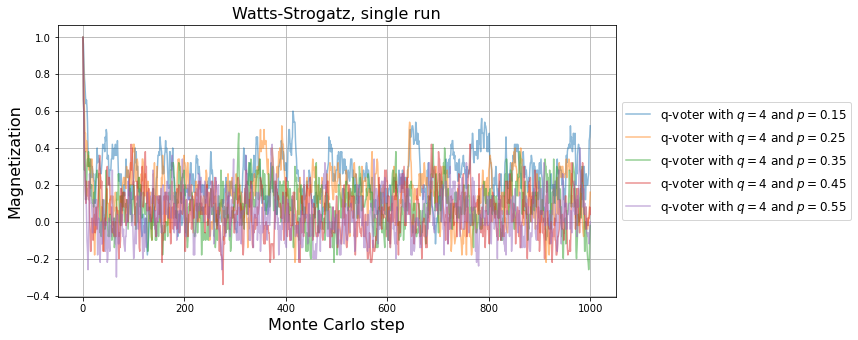

In [10]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
ax.plot(m_ops1, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[0]),alpha=0.5)
ax.plot(m_ops2, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[1]),alpha=0.5)
ax.plot(m_ops3, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[2]),alpha=0.5)
ax.plot(m_ops4, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[3]),alpha=0.5)
ax.plot(m_ops5, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[4]),alpha=0.5)

ax.set_title('Watts-Strogatz, single run',fontsize=16)
ax.set_xlabel('Monte Carlo step',fontsize=16)
ax.set_ylabel('Magnetization',fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.grid();

It may be intresesting to see how it behaves at the beginning, so I also plot log scale for Monte Carlo steps

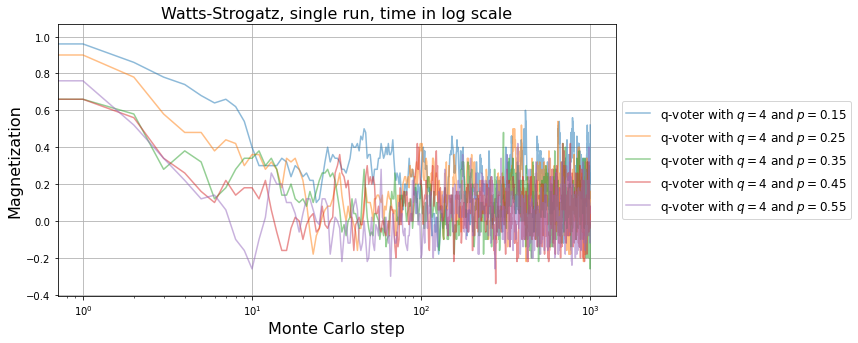

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
ax.plot(m_ops1, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[0]),alpha=0.5)
ax.plot(m_ops2, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[1]),alpha=0.5)
ax.plot(m_ops3, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[2]),alpha=0.5)
ax.plot(m_ops4, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[3]),alpha=0.5)
ax.plot(m_ops5, label=r'q-voter with $q=4$ and $p=$'+str(p_vals[4]),alpha=0.5)

ax.set_title('Watts-Strogatz, single run, time in log scale',fontsize=16)
ax.set_xlabel('Monte Carlo step',fontsize=16)
ax.set_ylabel('Magnetization',fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.set_xscale('log')
ax.grid();

We can see that for all p it goes to 0 and then oscilates around that. For bigger p, this goes faster

#### Now average

Also averaging is done in different way, as it was first task I have done.

In [14]:
def average_plot(G, p_val:float):
    m_ops_matrix = q_voter(G, q=4, p=p_val, MC_step=1000)
    for _ in range(100-1):
        m_ops = q_voter(G, q=4, p=p_val, MC_step=1000)
        m_ops_matrix = np.vstack([m_ops_matrix, m_ops])
    #averager, legth = np.shape(m_ops_matrix)
    val_m = [sum(m_ops_matrix[:,i])/100 for i in range(1001)]
    return val_m

In [15]:
m_ops_matrix = q_voter(G_w,q=4,p=0.1,MC_step=1000)
for _ in range(100-1):
    m_ops= q_voter(G_w,q=4,p=0.1,MC_step=1000)
    m_ops_matrix = np.vstack([m_ops_matrix, m_ops])

In [16]:
averager, legth = np.shape(m_ops_matrix)
val_m = [sum(m_ops_matrix[:,i])/averager for i in range(legth)]

In [17]:
mean_vals_4 = [average_plot(G_w, pi) for pi in p_vals]

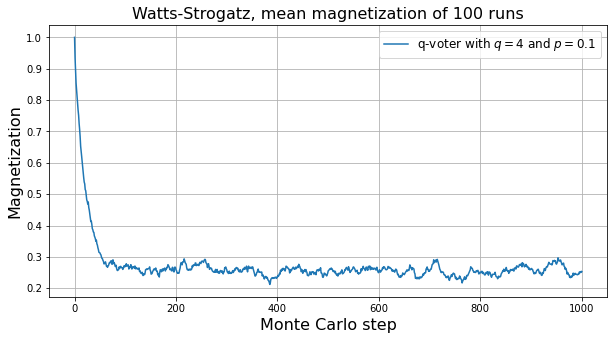

In [18]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
ax.plot(val_m, label=r'q-voter with $q=4$ and $p=0.1$')
ax.set_title('Watts-Strogatz, mean magnetization of 100 runs',fontsize=16)
ax.set_xlabel('Monte Carlo step',fontsize=16)
ax.set_ylabel('Magnetization',fontsize=16)
ax.legend(fontsize=12)
ax.grid();

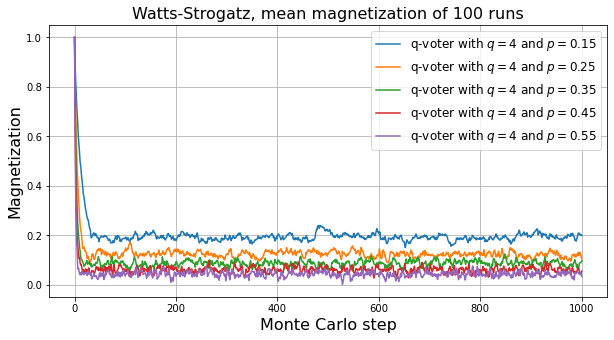

In [19]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
for i in range(5):
    ax.plot(mean_vals_4[i], label=r'q-voter with $q=4$ and $p=$'+str(p_vals[i]))
ax.set_title('Watts-Strogatz, mean magnetization of 100 runs',fontsize=16)
ax.set_xlabel('Monte Carlo step',fontsize=16)
ax.set_ylabel('Magnetization',fontsize=16)
ax.legend(fontsize=12)
ax.grid();

We can see that here also all plots quickly go down, but for smaller p, they usually dont reach 0 and stay over it.

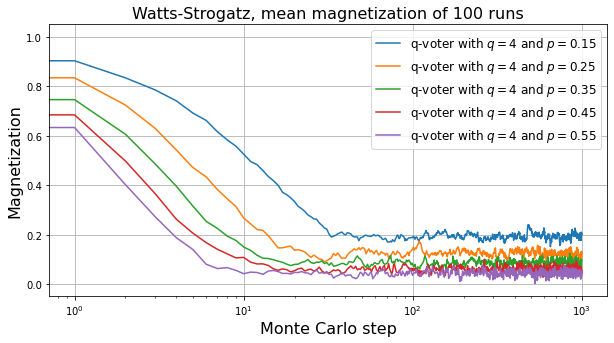

In [20]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
for i in range(5):
    ax.plot(mean_vals_4[i], label=r'q-voter with $q=4$ and $p=$'+str(p_vals[i]))
ax.set_title('Watts-Strogatz, mean magnetization of 100 runs',fontsize=16)
ax.set_xlabel('Monte Carlo step',fontsize=16)
ax.set_ylabel('Magnetization',fontsize=16)
ax.legend(fontsize=12)
ax.set_xscale('log')
ax.grid();

And again log scale, so we can see that bigger probability $p$ leads to magnetization faster going to values closer to 0. Also we can see that again smaller p means slower 'falling'.

In [101]:
#with open('Dot_4_average.pickle', 'wb') as f:
#    pickle.dump(mean_vals_4, f)

In [102]:
#with open('Dot_4_average.pickle', 'rb') as f:
#    again = pickle.load(f)

# 5th dot

#### Plot the average final magnetization as a function of independence factor p for:

In [27]:
ps5 = np.arange(0.0, 0.52, 0.02)

Now I will be using results from task 2-3. Last column will be final magnetization depending on value of p

#### a) q=3, different topologies (one plot)

In [25]:
with open('Comp_3', 'rb') as f:
    c_g_3 = pickle.load(f)
with open('BA_3', 'rb') as f:
    ba_g_3 = pickle.load(f)
with open('WS_001_3', 'rb') as f:
    ws1_g_3 = pickle.load(f)
with open('WS_02_3', 'rb') as f:
    ws2_g_3 = pickle.load(f)

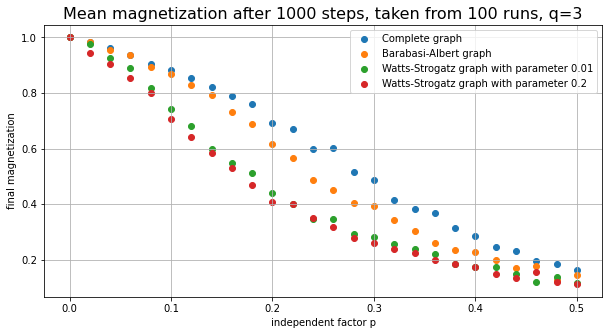

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(ps5, c_g_3[:,-1], label='Complete graph')
ax.scatter(ps5, ba_g_3[:,-1], label='Barabasi-Albert graph')
ax.scatter(ps5, ws1_g_3[:,-1], label='Watts-Strogatz graph with parameter 0.01')
ax.scatter(ps5, ws2_g_3[:,-1], label='Watts-Strogatz graph with parameter 0.2')
ax.legend();
ax.grid();
ax.set_title('Mean magnetization after 1000 steps, taken from 100 runs, q=3', fontsize=16);
ax.set_xlabel('independent factor p');
ax.set_ylabel('final magnetization');

We can see that bigger p leads to smaller magnetization at the end. Also rate at which these goes down is smaller for complete graph and Barabasi. It may be due to fact, that for complete graph, there are no communities, so whole network can pressure these with other opinion to change it back. As for Barabasi, maybe presence of very popular node which has opinion 1 can lead many of other nodes not to change their opinion.

#### b) q = 4 and different network topologies (one plot)

In [29]:
with open('Comp_4', 'rb') as f:
    c_g_4 = pickle.load(f)
with open('BA_4', 'rb') as f:
    ba_g_4 = pickle.load(f)
with open('WS_001_4', 'rb') as f:
    ws1_g_4 = pickle.load(f)
with open('WS_02_4', 'rb') as f:
    ws2_g_4 = pickle.load(f)

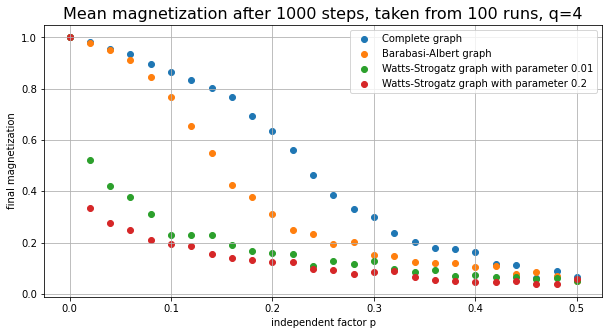

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(ps5, c_g_4[:,-1], label='Complete graph')
ax.scatter(ps5, ba_g_4[:,-1], label='Barabasi-Albert graph')
ax.scatter(ps5, ws1_g_4[:,-1], label='Watts-Strogatz graph with parameter 0.01')
ax.scatter(ps5, ws2_g_4[:,-1], label='Watts-Strogatz graph with parameter 0.2')
ax.legend()
ax.grid()
ax.set_title('Mean magnetization after 1000 steps, taken from 100 runs, q=4', fontsize=16);
ax.set_xlabel('independent factor p');
ax.set_ylabel('final magnetization');

Watts-Strogatz graphs now are even faster getting to zero. As I said before, it may be due to fact, that there are more small communities within these 2 networks

#### c) WS(100,4,0.01) network and different values of q (one plot)

In [31]:
with open('WS_001_1', 'rb') as f:
    ws1_g_1 = pickle.load(f)
with open('WS_001_2', 'rb') as f:
    ws1_g_2 = pickle.load(f)
with open('WS_001_3', 'rb') as f:
    ws1_g_3 = pickle.load(f)
with open('WS_001_4', 'rb') as f:
    ws1_g_4 = pickle.load(f)

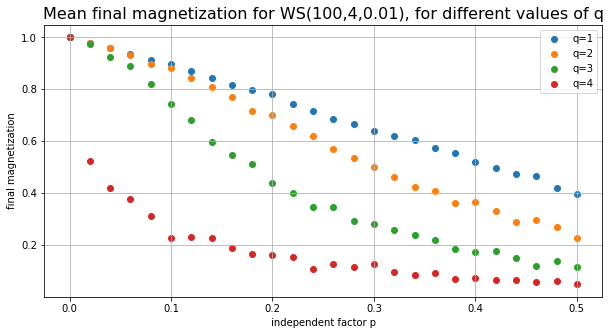

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(ps5, ws1_g_1[:,-1], label='q=1')
ax.scatter(ps5, ws1_g_2[:,-1], label='q=2')
ax.scatter(ps5, ws1_g_3[:,-1], label='q=3')
ax.scatter(ps5, ws1_g_4[:,-1], label='q=4')
ax.legend()
ax.grid()
ax.set_title('Mean final magnetization for WS(100,4,0.01), for different values of q', fontsize=16);
ax.set_xlabel('independent factor p');
ax.set_ylabel('final magnetization');

We can see that for smaller q rate of going down to 0 is slower, maybe with only 1 neighbour its to much random?